# Interactive Demo

This is an interactive version of the demo. It runs over the same mock data using the same procedure as the implementation in the default *prospector.py* Python script. 

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
import numpy as np
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [2]:
import fsps
import sedpy
import prospect

## Setup

We now want to initialize our model.

In [3]:
from prospect.models import model_setup

The overall or meta-parameters contolling how the fit is done are stored in the ``run_params`` dictionary, which is a mix of options
  1. defined in the parameter file
  2. specified at the command line (if not running in interactive mode.)

Let's load them from the parameter file:

In [4]:
clargs = {'param_file':'demo_mock_params.py'}
run_params = model_setup.get_run_params(argv='demo_mock_params.py', **clargs)
print(run_params)

{'tau': 3.0, 'verbose': True, 'niter': 512, 'normalize_spectrum': False, 'initial_disp': 0.1, 'do_levenburg': True, 'outfile': 'output/demo_mock', 'nburn': [32, 32, 64], 'nestle_npoints': 200, 'maxfev': 5000, 'do_powell': False, 'nwalkers': 128, 'mass': 10000000000.0, 'param_file': 'demo_mock_params.py', 'ftol': 5e-06, 'logzsol': -0.5, 'dust2': 0.3, 'tage': 12.0, 'zred': 0.1, 'zcontinuous': 1, 'nmin': 10, 'debug': False, 'snr': 20.0, 'add_noise': False, 'nestle_method': 'single', 'logify_spectrum': False, 'nestle_maxcall': 1000000}


Our model will be composed of four components:
- an **stellar population synthesis (SPS)** model for the underlying physical parameters,
- an underlying **statistical model** composed of a set of parameters, priors, etc., 
- a **noise model** for the underlying calibration vector, and
- a set of **observations** we are trying to fit.

See the *demo_mock_params.py* file for additional info on the specific parameters we are initializing here.

The SPS model specified in the ``load_obs`` method of the parameter file can be one of several different types, corresponding to different SFH parameterizations.  Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations as described in the FSPS manual with `sfh_type` of 1, 4, or 5.

In [5]:
# load sps model (default)
sps = model_setup.load_sps(**run_params)
print(sps)

For now we set the noise models to ``None``, which means that the default simple $\chi^2$ style likelihood will be used.

In [6]:
# load noise model (none)
spec_noise, phot_noise = model_setup.load_gp(**run_params)

The model object keeps track of the fit parameters and their priors.

In [7]:
# demo model
model = model_setup.load_model(**run_params)

The `obs` dictionary contains all our observational data, from which we are attempting to infer posterior PDFs for the parameters.  Guidelines for units and what keys must be in the `obs` dictionary can be found in the documentation.

In [8]:
# demo data (generated from the script)
obs = model_setup.load_obs(**run_params)
print('Mock S/N={}'.format(obs['mock_snr']))
if run_params['add_noise']:
    print('Noise realization added to mock photometry')
else:
    print('No noise added to mock photometry')

reading py script demo_mock_params.py
Mock S/N=20.0
No noise added to mock photometry


Now that we've initialized the components of our model, we need to define how we want to compare our model to the data by establishing the appropriate **likelihood**. In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from Prospector.

In [9]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

In [10]:
def lnprobfn(theta):
    """Given a parameter vector, a dictionary of observational data 
    and a model object, return the ln of the posterior. 
    This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    # Calculate prior probability and exit if not within prior
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate mean model
    t1 = time.time()
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return -np.infty
    d1 = time.time() - t1
    vectors = {}  # This would be used for noise model weight functions

    # Calculate likelihoods
    t2 = time.time()
    lnp_spec = lnlike_spec(spec, obs=obs, spec_noise=spec_noise)
    lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise)
    d2 = time.time() - t2
    if verbose:
        write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

    return lnp_prior + lnp_phot + lnp_spec


## Running Prospector

### Outputs

Before we start running anything, let's just check whether we can write out our fits to an HDF5 file. If not, we'll just dump them at the end.

In [11]:
from prospect.io import write_results

In [12]:
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = outroot + '_mcmc.h5'
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

Writing to file output/demo_mock_1497912659_mcmc.h5
Could not JSON serialize mock_params, pickled instead


### Model Preview

Let's also take a quick look at our model/data to get a sense of what we're dealing with and what we're fitting for.

In [13]:
print 'Free params:', model.free_params
print 'Fixed params:', model.fixed_params

Free params: ['mass', 'logzsol', 'tau', 'tage', 'dust2']
Fixed params: ['zred', 'sfh', 'pmetals', 'fage_burst', 'tburst', 'fburst', 'dust1', 'dust_tesc', 'dust_index', 'dust1_index', 'dust_type', 'add_dust_emission', 'duste_umin', 'tpagb_norm_type', 'add_agb_dust_model', 'agb_dust', 'add_neb_emission', 'gas_logz', 'gas_logu', 'phot_jitter']


So we're fitting for 5 parameters here:
- stellar mass $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), 
- age $t$ of the galaxy, and 
- dust attenuation of old stellar populations $A_V$.

Everything else here is fixed explicitly in the *demo_mock_params.py* file.  There are many other parameters that are set implicitly in the FSPS defaults.

### SED Preview

Let's now see what our model and data look like.

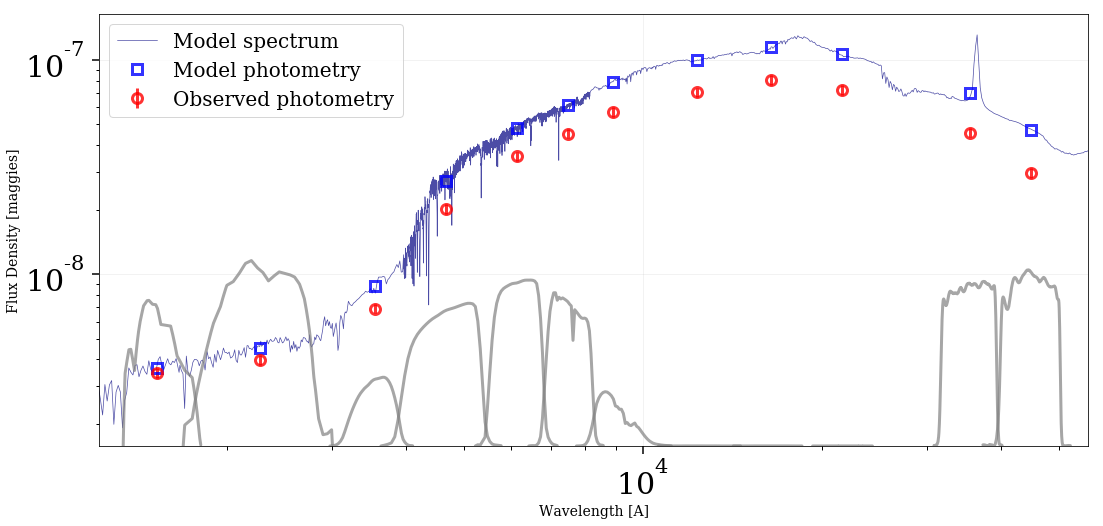

In [20]:
wspec = sps.csp.wavelengths # *restframe* spectral wavelengths
a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = np.array([f.wave_effective for f in obs['filters']])
# initial parameters based on `init` values of model_params
initial_theta = model.rectify_theta(model.initial_theta)
# generate model
out_init = model.mean_model(initial_theta, obs, sps=sps) 
mspec_init, mphot_init, mextra_init = out_init

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec * a, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
figure(figsize=(16,8))

# plot model + data
loglog(wspec * a, mspec_init, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, mphot_init, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Minimization Step

We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.

In [21]:
from prospect import fitting
from scipy.optimize import least_squares

In [22]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    """
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return -np.infty

    # Generate mean model
    t1 = time.time()
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return -np.infty
    d1 = time.time() - t1

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

verbose = False # don't output function calls

# start minimization
min_method = 'levenburg-marquardt'
nmin = 5 # We'll start from 5 places, 4 of which are drawn from the prior
ts = time.time()
pinitial = fitting.minimizer_ball(model.initial_theta.copy(), nmin, model)
guesses = []
for i, pinit in enumerate(pinitial): #loop over initial guesses
    res = least_squares(chivecfn, pinit, method='lm', x_scale='jac',
                        xtol=1e-16, ftol=1e-16)
    guesses.append(res)

# Calculate chi-square of the results, and choose the best one
chisq = [np.sum(r.fun**2) for r in guesses]
best = np.argmin(chisq)
initial_center = fitting.reinitialize(guesses[best].x, model,
                        edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = None
pdur = time.time() - ts

# output results
print('done {0} in {1}s'.format(min_method, pdur))
print('best {0} guess: {1}'.format(min_method, initial_center))
print('best {0} chi-sq: {1}'.format(min_method, chisq[best]))

/usr/local/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`ftol`", EPS))
/usr/local/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`xtol`", EPS))
/usr/local/lib/python2.7/site-packages/prospect-d4e020f-py2.7.egg/prospect/models/priors.py:141: RuntimeWarning: divide by zero encountered in log


done levenburg-marquardt in 28.5192930698s
best levenburg-marquardt guess: [  1.00000000e+10  -5.00000000e-01   3.00000000e+00   1.20000000e+01
   3.00000000e-01]
best levenburg-marquardt chi-sq: 5.31405751531e-21


Note that creating a new model with FSPS is somewhat time-intensive, but once the relevant model(s) have been loaded they are subsequently stored in cache so similar models can be generated much more quickly.

Now let's see how our model looks.

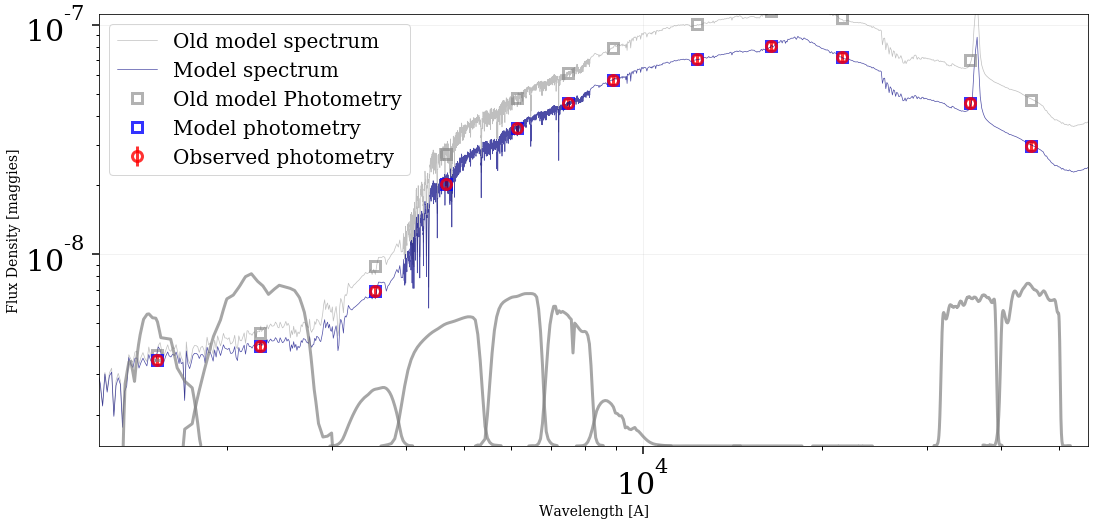

In [24]:
# initial parameters
theta = model.rectify_theta(initial_center)
# generate model
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec*a, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
figure(figsize=(16,8))

# plot Data, models, and old models
loglog(wspec * a, mspec_init, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, mphot_init, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec * a, mspec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Sampling the Posterior

Now that we're somewhat burned in, we can begin sampling from the posterior using **Markov Chain Monte Carlo** (MCMC). Prospector by default uses **emcee**, and will try to parallelize the process over multiple cores when available through MPI and mpi4py. In this interactive notebook though we will assume single-threaded operation. Let's go ahead and start sampling!

In [25]:
postkwargs = {} #any keyord arguments to the lnpostfn would go here.

fout = sys.stdout
fnull = open(os.devnull, 'w')
sys.stdout = fnull

tstart = time.time()  # time it
out = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
                                postkwargs=postkwargs, 
                                initial_prob=initial_prob,
                                pool=None, hdf5=hfile, **run_params)
esampler, burn_p0, burn_prob0 = out
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

done emcee in 616.326513052s


Now that everything's all set, let's save our results to disk.  These will be written to 2 or 3 files beginning with the value of `outroot`.

In [27]:
write_results.write_pickles(run_params, model, obs, esampler, guesses,
                            outroot=outroot, toptimize=pdur, tsample=edur,
                            sampling_initial_center=initial_center,
                            post_burnin_center=burn_p0,
                            post_burnin_prob=burn_prob0)

if hfile is None:
    hfile = hfilename
write_results.write_hdf5(hfile, run_params, model, obs, esampler, 
                         guesses,
                         toptimize=pdur, tsample=edur,
                         sampling_initial_center=initial_center,
                         post_burnin_center=burn_p0,
                         post_burnin_prob=burn_prob0)

print('Finished')

Finished


## Visualizing the Results

There are a few basic plotting tools available to do a quick check on the results available in *prospect.io.read_results* and *prospect.utils.plotting*. We'll hack a few of these together in *plot_utils* here in the demo folder to make them a bit more amenable to plotting in this notebook.

In [28]:
import plot_utils as pread
from prospect.io.read_results import results_from
print(outroot)

output/demo_mock_1497912659


Reading our results from our Pickle or HDF5 file is straightforward.

In [30]:
# grab results, powell results, and our corresponding models
res, pr, mod = results_from("{}_mcmc.h5".format(outroot))

To see how our MCMC samples look, we can examine a few traces.

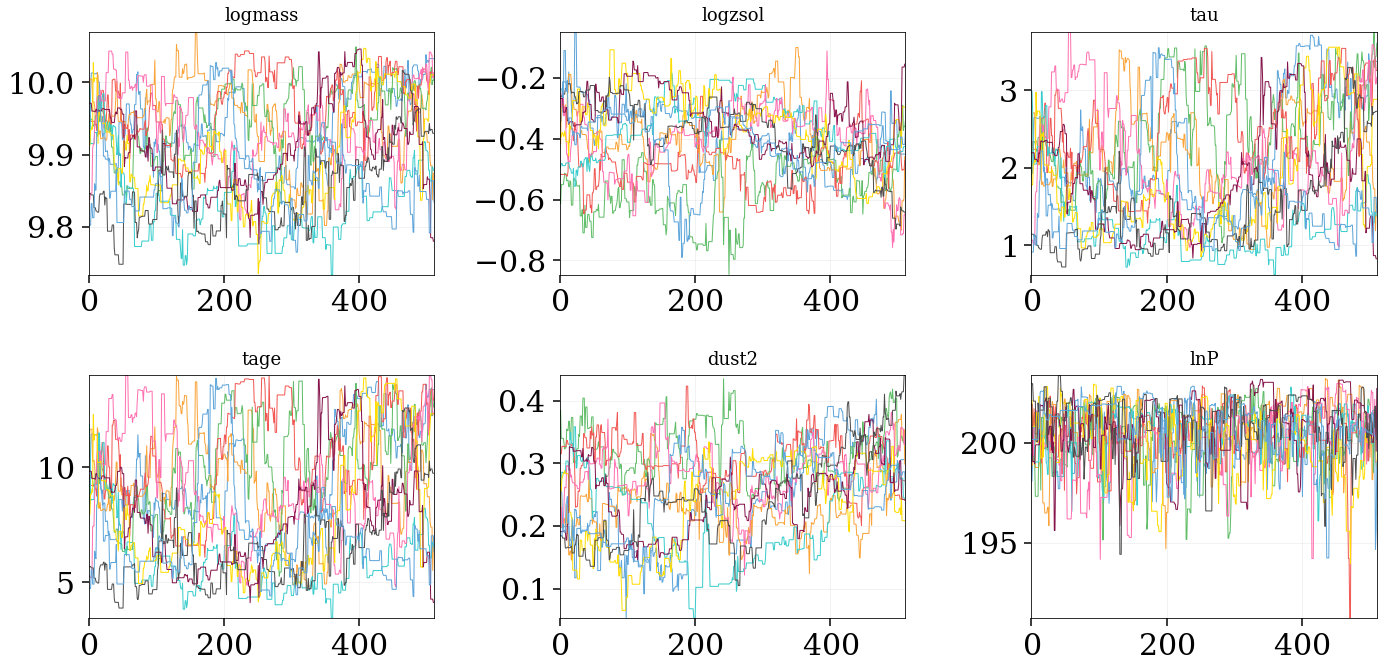

In [33]:
choice = np.random.choice
tracefig = pread.param_evol(res, figsize=(20,10), 
                            chains=choice(128, size=10, replace=False))

Our samples more generally can be shown using a corner/triangle plot.

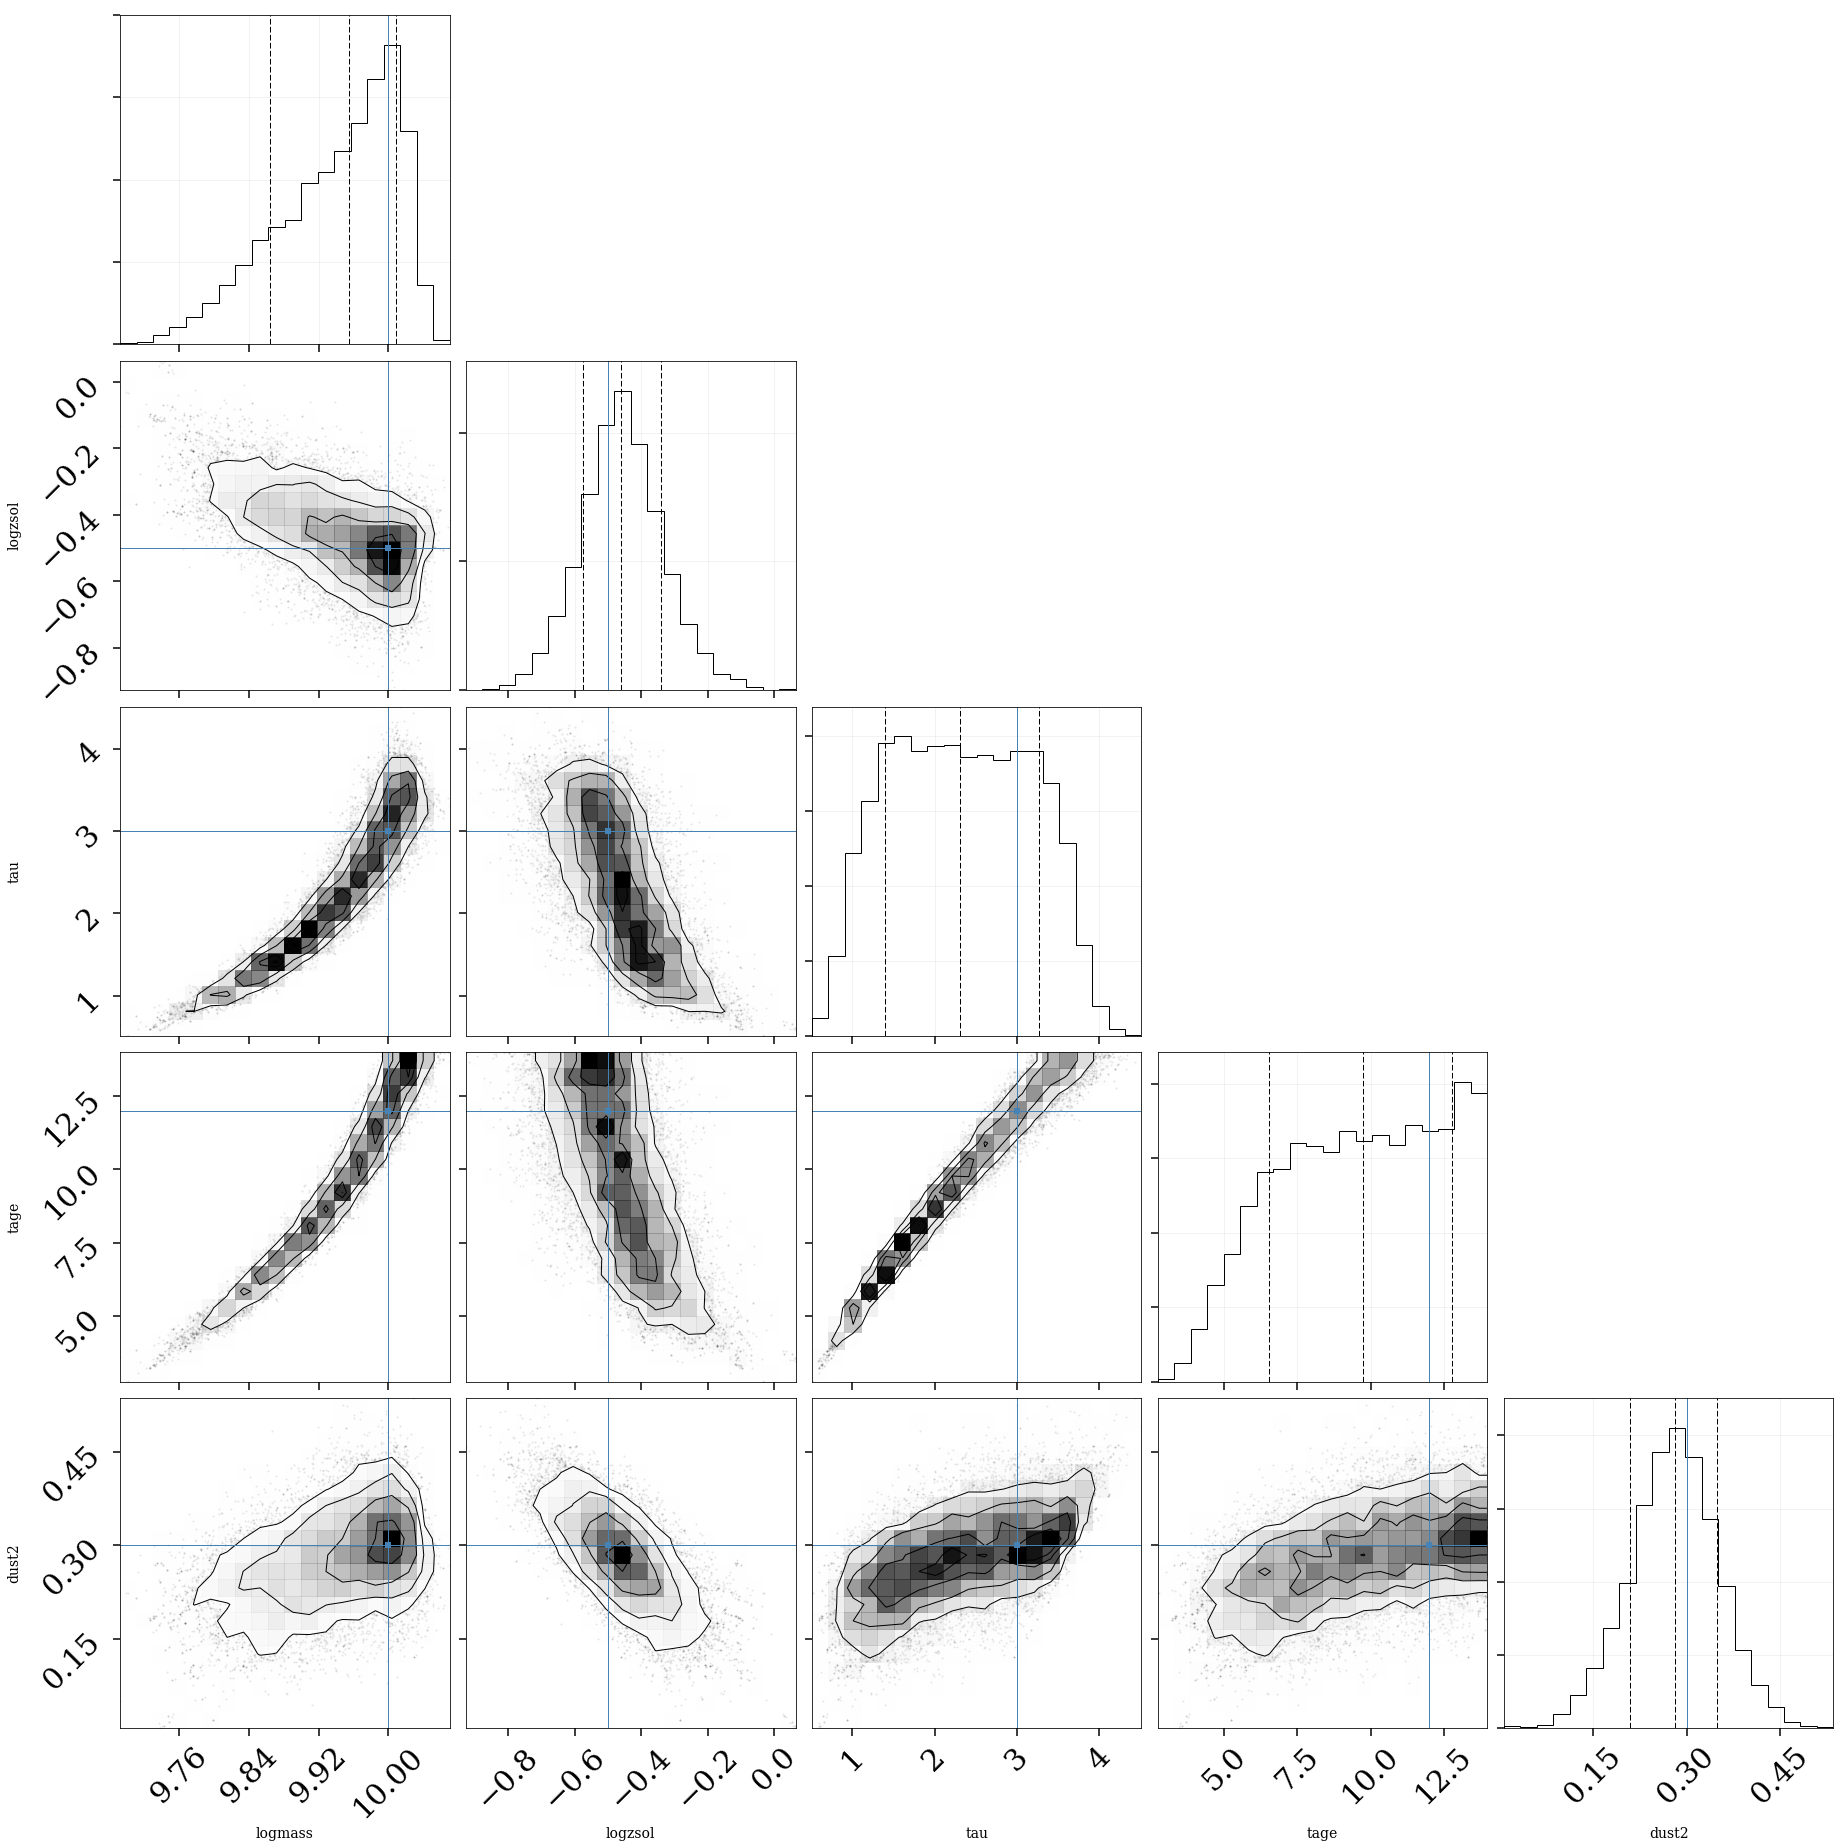

In [35]:
theta_truth = np.array([run_params[i] 
                        for i in ['mass','logzsol','tau','tage','dust2']])
theta_truth[0] = np.log10(theta_truth[0])
cornerfig = pread.subtriangle(res, start=0, thin=5, truths=theta_truth, 
                              fig=subplots(5,5,figsize=(27,27))[0])

Finally, let's just take a look at a random model drawn from our chain.

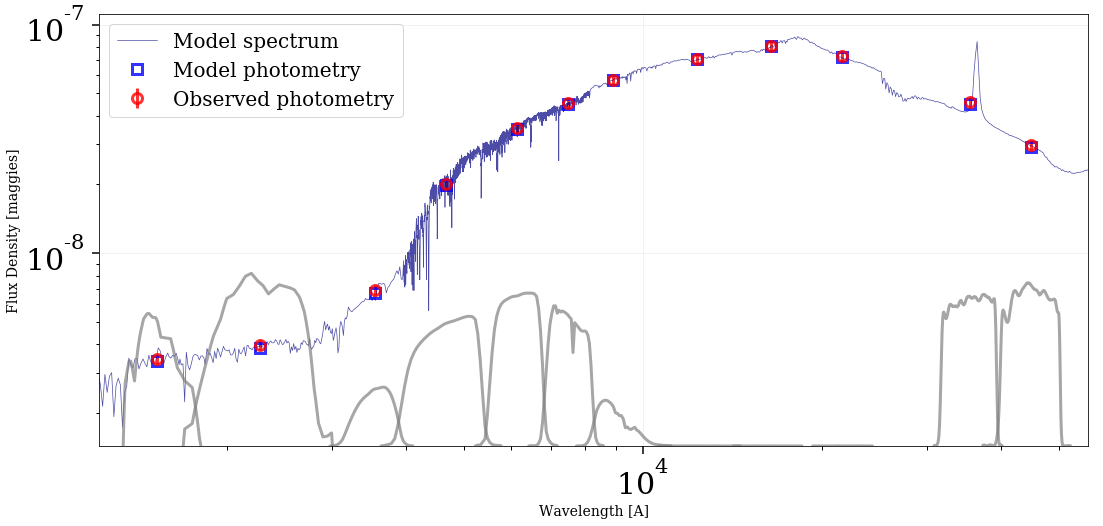

In [39]:
# randomly chosen parameters from chain
randint = np.random.randint
nwalkers, niter = run_params['nwalkers'], run_params['niter']
theta = res['chain'][randint(nwalkers), randint(niter)]
# generate model
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec * a, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
figure(figsize=(16,8))

# plot data and model
loglog(wspec * a, mspec, label='Model spectrum',
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()